Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas_profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [3]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np


# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)
# Convert LAND_SQUARE_FEET to int
df['LAND_SQUARE_FEET'] = pd.to_numeric(df['LAND_SQUARE_FEET'].str.replace(',',''),errors='coerce')
# Make zeroes in YEAR_BUILT a NaN
df['YEAR_BUILT'][df['YEAR_BUILT']==0] = np.NaN

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [6]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,10733.0,1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,2962.0,15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,2074.0,11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0.0,500.0,NaN,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0.0,6406.0,NaN,2,R1,0,01/01/2019


Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million

In [0]:
df = df[df['BUILDING_CLASS_CATEGORY']=='01 ONE FAMILY DWELLINGS']
# limit outliers in sale price
df = df[(df['SALE_PRICE']>100000) & (df['SALE_PRICE']<2000000)]

Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.  
Do one-hot encoding of categorical features.

In [0]:
# Convert SALE_DATE column to datetime
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'],infer_datetime_format=True)

In [0]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True,cols=['BUILDING_CLASS_AT_TIME_OF_SALE','BUILDING_CLASS_AT_PRESENT','TAX_CLASS_AT_PRESENT','NEIGHBORHOOD','BOROUGH'])

In [0]:
df_encoded = encoder.fit_transform(df)

In [11]:
#Keep only useful numeric columns for transfer
drops = ['EASE-MENT','APARTMENT_NUMBER','BUILDING_CLASS_CATEGORY','ADDRESS','SALE_DATE']
useful = set(df_encoded.columns) - set(drops)
print(useful)
# Train/test split
cutoff_idx = df['SALE_DATE'].dt.month != 4
train = df_encoded[useful][cutoff_idx]
test = df_encoded[useful][~cutoff_idx]
train.shape, test.shape

{'TAX_CLASS_AT_PRESENT_1D', 'SALE_PRICE', 'NEIGHBORHOOD_BEDFORD STUYVESANT', 'BUILDING_CLASS_AT_PRESENT_B3', 'BUILDING_CLASS_AT_PRESENT_A2', 'TAX_CLASS_AT_PRESENT_1', 'BOROUGH_2', 'TOTAL_UNITS', 'TAX_CLASS_AT_TIME_OF_SALE', 'NEIGHBORHOOD_FLUSHING-NORTH', 'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_TIME_OF_SALE_A5', 'GROSS_SQUARE_FEET', 'BUILDING_CLASS_AT_PRESENT_S1', 'COMMERCIAL_UNITS', 'BUILDING_CLASS_AT_PRESENT_A4', 'BUILDING_CLASS_AT_TIME_OF_SALE_A2', 'NEIGHBORHOOD_FOREST HILLS', 'BOROUGH_4', 'BUILDING_CLASS_AT_TIME_OF_SALE_A9', 'BUILDING_CLASS_AT_TIME_OF_SALE_S1', 'NEIGHBORHOOD_ASTORIA', 'LOT', 'BUILDING_CLASS_AT_TIME_OF_SALE_A6', 'BUILDING_CLASS_AT_TIME_OF_SALE_S0', 'BUILDING_CLASS_AT_TIME_OF_SALE_A1', 'BUILDING_CLASS_AT_PRESENT_A0', 'BUILDING_CLASS_AT_PRESENT_A6', 'LAND_SQUARE_FEET', 'NEIGHBORHOOD_BOROUGH PARK', 'BOROUGH_3', 'BUILDING_CLASS_AT_PRESENT_A3', 'BUILDING_CLASS_AT_PRESENT_A9', 'BUILDING_CLASS_AT_TIME_OF_SALE_A3', 'BOROUGH_1', 'BUILDING_CLASS_AT_PRESENT_A1', 'BUI

((2507, 48), (644, 48))

In [0]:
#df.profile_report()

 Do feature selection with SelectKBest.


Fit a ridge regression model with multiple features. Use the normalize=True parameter (or do feature scaling beforehand — use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)

In [0]:
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

In [0]:
#Establish target/non-target columns
target = 'SALE_PRICE'
not_target = set(train.columns) - set(target)
#Establish X/Y 
y_train = train[target]
x_train = train[not_target]
y_test = test[target]
x_test = test[not_target]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 1  3  8 24 34 46] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 1  3  8 24 34 46] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb 

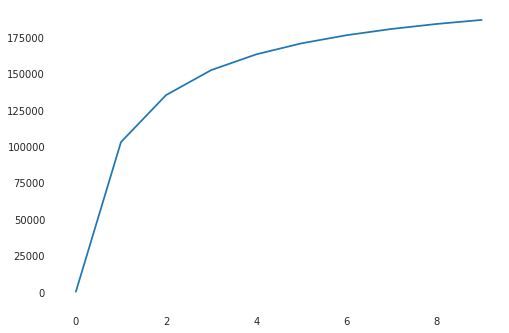

In [52]:
# Plot reduction in error of model with increasing alpha
mae = []
for alpha in range(0,10):
  selector = SelectKBest(k=20);
  x_train_selected = selector.fit_transform(x_train,y=y_train);
  x_test_selected = selector.transform(x_test);

  model = Ridge(alpha=alpha, normalize=True);
  model.fit(x_train_selected, y_train);
  y_pred = model.predict(x_test_selected);
  mae.append(mean_absolute_error(y_train,model.predict(x_train_selected)))

sns.lineplot(x=range(0,10),y=mae);


 Get mean absolute error for the test set.

In [53]:
model = Ridge(alpha=0, normalize=True);
model.fit(x_train_selected, y_train);
y_pred = model.predict(x_test_selected);
mean_absolute_error(y_test,y_pred)


5.663413648777147